In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

In [2]:
df = pd.read_csv('translated_dataset.csv')

df.head(10)

,cid,submittedVideoUrl,text,label,translated_text
0,7.424290e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,sayangnya orang-orang terdekat yang justru membuat mental kita sakit dan lelah,0.0,unfortunately the closest people who actually make us mentally sick and tired
1,7.424297e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"justru malah org trdekat yg menghancurkan mental ku, aku tdk prcya siapapun, caraku mengatasi ini semua dgn meditasi agar lbih tenang",1.0,"In fact, the closest one who destroyed my mentality, I did not feel anyone, the way I overcome this all with meditation so that it is more calm"
2,7.467563e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,halo ka indah sundari,1.0,Hello Ka Indah Sundari
3,7.424316e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,justru orang terdekat malah jadi penyebabnya,1.0,precisely the closest person is the cause
4,7.455553e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,ka tolong aku,1.0,Ka help me
5,7.424138e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"banyak yg pengen aku ceritain, tp g bisa, g tau kenapa g bisa keluar unek² ini",1.0,"I want to tell you a lot, but I can't, I don't know why I can't come out this"
6,7.424361e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"tapi ya memang harus dekat dengan tuhan, banyak dzikir, tahajud, shalawat dan baca al-qur'an.. itu yg buat pikiran dan hati kita jernih sehingga kita bisa menemukan solusi untuk mengatasinya..",1.0,"But yes, it must be close to God, many dhikr, tahajud, prayers and read the Qur'an ... that's what makes our minds and hearts clear so that we can find solutions to overcome them .."
7,7.437372e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,suka sedih dibilang masalah mental karna jauh dari tuhann,0.0,like sad to say mental problems because it is far from God
8,7.425095e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"""akan ada masa dimana kamu tidak menemukan kebahagiaan, kecuali dengan mengasingkan diri dari keramaian"" bener kata sayyidina ali",1.0,"""There will be a time when you do not find happiness, except by alienating yourself from the crowd"" Really the word Sayyidina Ali"
9,7.425306e+18,https://www.tiktok.com/@sundarindah/video/7424130682529516805,"aku seorang ibu rumah tangga, sudah lama sekali aku selalu berbicara sndrian ketika aku sndri, berbicara sprti sdg mengobrol pdhl aku sdg sndrian, sebelumnya aku merasa biasa",0.0,"I am a housewife, it's been a long time since I always spoke sndrian when I was, talking like I was talking to me, I was on, before I felt normal before"


In [3]:
# Set up Indonesian stopwords and stemmer
stop_factory = StopWordRemoverFactory()
stopwords_sastrawi = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()
custom_stopwords = {
    # Pronouns & common personal references
    'aku', 'kamu', 'dia', 'kami', 'kita', 'mereka', 'saya', 'anda', 'gw', 'gue', 'lu', 'loe', 'lo', 'gua', 'kak',
    
    # Formal stopwords
    'yang', 'dan', 'di', 'ke', 'dari', 'pada', 'dengan', 'untuk', 'dalam', 'adalah', 'itu', 'ini',
    'juga', 'sebagai', 'oleh', 'karena', 'agar', 'atau', 'tetapi', 'namun', 'sehingga', 'supaya',
    'bagi', 'tanpa', 'bahwa', 'kalau', 'jika', 'saat', 'sebelum', 'sesudah', 'setelah', 'sementara',
    'sambil', 'sedangkan', 'seperti', 'hingga', 'meskipun',

    # Common verbs & auxiliaries
    'adalah', 'ialah', 'merupakan', 'bukan', 'sudah', 'belum', 'akan', 'lagi', 'pernah',
    'harus', 'mau', 'dapat', 'bisa',

    # Informal abbreviations/slang
    'gak', 'ga', 'nggak', 'ngga', 'tdk', 'ngerti', 'sih', 'aja', 'kok', 'dong', 'nih', 'deh',
    'ya', 'yah', 'yee', 'loh', 'lah', 'cie', 'eh', 'btw', 'kalo', 'kalau', 'tp', 'yg', 'dr', 'pd', 'trs', 'klo'

    # Internet filler
    'wkwk', 'wkwkwk', 'haha', 'hehe', 'huhu', 'ckck', 'lol', 'lmao', 'anjay', 'banget', 'mantul',

    # Temporal
    'kemarin', 'besok', 'nanti', 'sekarang', 'tadi', 'barusan',

    # Common question words
    'apa', 'kenapa', 'mengapa', 'dimana', 'kapan', 'siapa', 'bagaimana'
}

extended_stopwords = stopwords_sastrawi.union(custom_stopwords)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in extended_stopwords])
    text = stemmer.stem(text)  # stemming in Bahasa Indonesia
    return text


In [4]:
text_column = 'text'
label_column = 'label'

df = df[[text_column, label_column]].dropna()
df[text_column] = df[text_column].astype(str).apply(preprocess_text)

if df[label_column].dtype != int:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

df.head(10)

,text,label
0,sayang orangorang dekat justru buat mental sakit lelah,0
1,justru malah org trdekat hancur mental ku prcya siapa cara atas semua dgn meditasi lbih tenang,1
2,halo ka indah sundari,1
3,justru orang dekat malah jadi sebab,1
4,ka,1
5,banyak ken ceritain g g tau g keluar unek,1
6,memang dekat tuhan banyak dzikir tahajud shalawat baca alquran buat pikir hati jernih temu solusi atas,1
7,suka sedih bilang masalah mental karna jauh tuhann,0
8,masa temu bahagia asing diri ramai bener kata sayyidina ali,1
9,orang ibu rumah tangga lama sekali selalu bicara sndrian sndri bicara sprti sdg obrol pdhl sdg sndrian belum rasa biasa,0


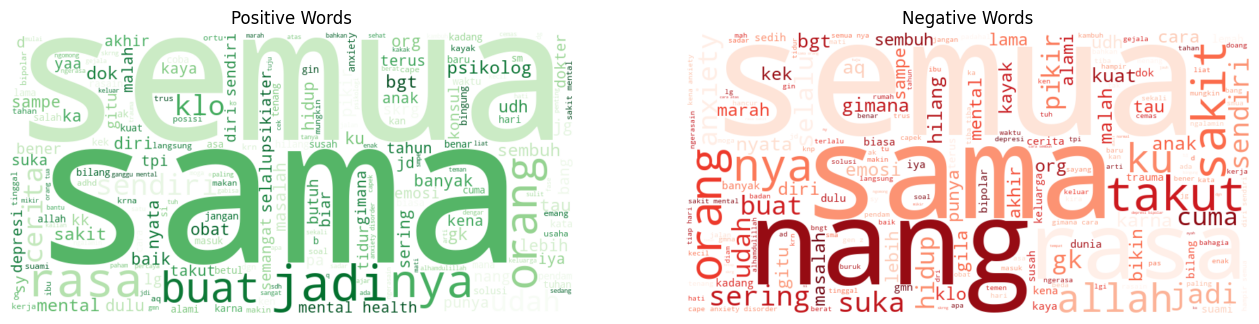

In [5]:
positive_texts = df[df[label_column] == 1][text_column]
negative_texts = df[df[label_column] == 0][text_column]

positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(' '.join(positive_texts))
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(negative_texts))

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [6]:
vocab_size = 10000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

word_index = tokenizer.word_index

In [7]:
embedding_index = {}
embedding_dim = 300  # FastText Indo = 300 dimensions

with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  # Skip the header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df[label_column], test_size=0.2, random_state=42)

In [9]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,321 (12.33 MB)

 Trainable params: 3,232,321 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - accuracy: 0.7371 - loss: 0.8911 - val_accuracy: 0.8121 - val_loss: 0.4470
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.8398 - loss: 0.3888 - val_accuracy: 0.8242 - val_loss: 0.4247
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.8805 - loss: 0.3031 - val_accuracy: 0.8118 - val_loss: 0.4804
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.9088 - loss: 0.2373 - val_accuracy: 0.8160 - val_loss: 0.4996
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.9260 - loss: 0.1934 - val_accuracy: 0.7989 - val_loss: 0.6350


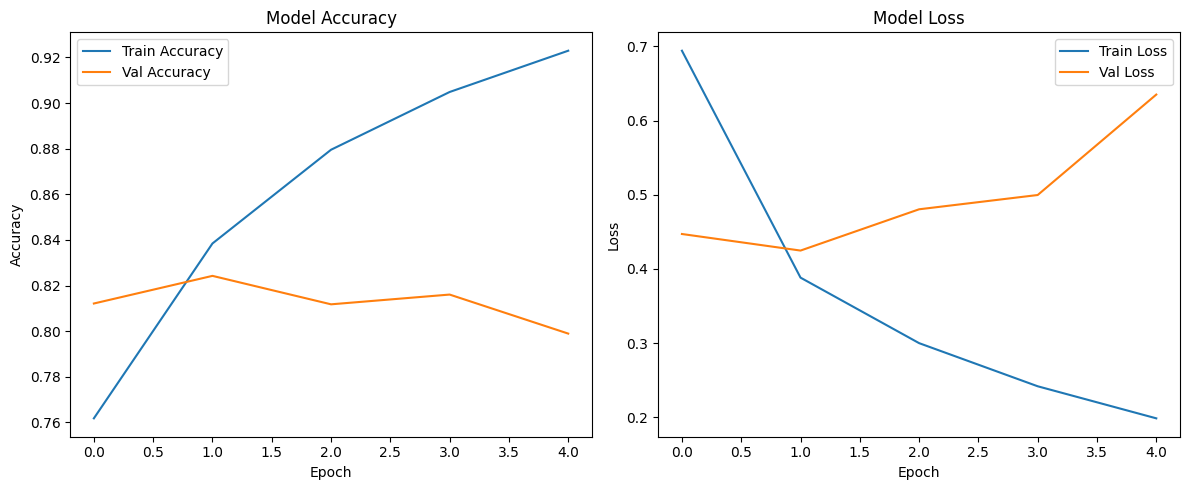

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


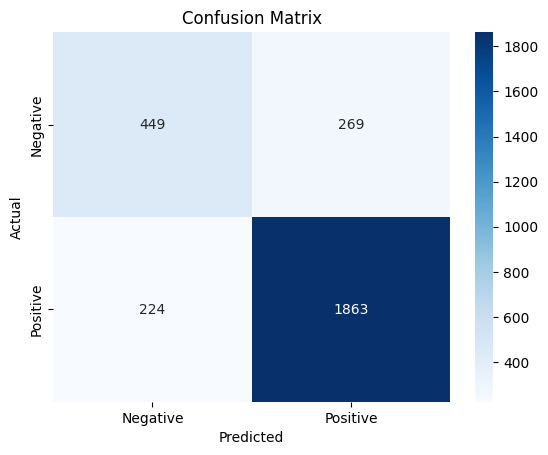


Classification Report:

              precision    recall  f1-score   support

    Negative       0.67      0.63      0.65       718
    Positive       0.87      0.89      0.88      2087

    accuracy                           0.82      2805
   macro avg       0.77      0.76      0.76      2805
weighted avg       0.82      0.82      0.82      2805



In [12]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [17]:
model.save('sentiment_model.h5')